In [1]:
from fastscape.models import basic_model
import numpy as np
import matplotlib.pyplot as plt
%load_ext xsimlab.ipython
plt.style.use('dark_background')

## Xarray-simlab process to incorporate the TopoStress component to FastScape

In [2]:
import numpy as np
import xsimlab as xs
import numba as nb
import xarray as xr
import TopoStresses as TS

from fastscape.processes import RasterGrid2D, SurfaceTopography

@xs.process
class TopoStress:
    nz = xs.variable(intent="in",
                     description="number of nodes in the z-direction",
                     default=5,
                    )
    zl = xs.variable(intent="in",
                     description="model depth",
                     default=10e3,
                     attrs={"units": "m"},
                    )
    rhog = xs.variable(intent="in",
                       description="product of density by gravitational acceleration",
                       default=27468,
                       attrs={"units": "kg/m^2/s^2"},
                      )
    ym = xs.variable(intent="in",
                     description="Young's modulus",
                     default=1e11,
                     attrs={"units": "Pa"},
                    )
    pr = xs.variable(intent="in",
                     description="Poisson's ratio",
                     default=0.25,
                    )
    ks = xs.variable(intent="in",
                     description="von Mises yield stress",
                     default=-1,
                     attrs={"units": "Pa"},
                    )
    exx = xs.variable(intent="in",
                      description="strain in x-direction",
                      default=0,
                     )
    eyy = xs.variable(intent="in",
                      description="strain in y-direction",
                      default=0,
                     )
    ibc = xs.variable(intent="in",
                      description="boundary condition",
                      default=1,
                     )
    sxx = xs.on_demand(dims=("y","x"),
                       description="surface deviatoric sxx",
                       attrs={"units": "Pa"},
                      )
    
    syy = xs.on_demand(dims=("y","x"),
                       description="surface deviatoric syy",
                       attrs={"units": "Pa"},
                      )

    szz = xs.on_demand(dims=("y","x"),
                       description="surface deviatoric szz",
                       attrs={"units": "Pa"},
                      )

    sxy = xs.on_demand(dims=("y","x"),
                       description="surface deviatoric sxy",
                       attrs={"units": "Pa"},
                      )

    szx = xs.on_demand(dims=("y","x"),
                       description="surface deviatoric szx",
                       attrs={"units": "Pa"},
                      )

    syz = xs.on_demand(dims=("y","x"),
                       description="surface deviatoric syz",
                       attrs={"units": "Pa"},
                      )

    press = xs.on_demand(dims=("y","x"),
                       description="pressure",
                       attrs={"units": "Pa"},
                      )

    j2d = xs.on_demand(dims=("y","x"),
                       description="second invariant of stress tensor",
                       attrs={"units": "Pa"},
                      )

    elevation = xs.foreign(SurfaceTopography, "elevation",
                           intent="in")
    shape = xs.foreign(RasterGrid2D, "shape",
                      intent="in")
    length = xs.foreign(RasterGrid2D, "shape",
                      intent="in")
    
    def run_step(self):
        self.stress_ = None   # reset the cached value at each time step
        
    @property
    def _stress(self):
        if self.stress_ is None:
            ny, nx = self.shape
            TS.topostresses_setup(nx, ny, self.nz)
            yl, xl = self.length
            TS.topostresses_set_xlylzl(xl, yl, self.zl)
            TS.topostresses_set_mechanical_properties(self.rhog,self.exx,self.eyy,self.ym,self.pr,self.ks)
            TS.topostresses_set_bc(self.ibc)
            TS.topostresses_set_h(self.elevation.flatten())
            TS.topostresses_execute()
            stress = np.zeros(6*ny*nx*self.nz)
            TS.topostresses_copy_stress(stress)
            TS.topostresses_destroy()
            self.stress_ = stress.reshape((6,self.nz,ny,nx))[:,-1,:,:]
        return self.stress_

    @sxx.compute
    def _sxx(self):
        return self._stress[0,:,:]

    @syy.compute
    def _syy(self):
        return self._stress[1,:,:]

    @szz.compute
    def _szz(self):
        return self._stress[2,:,:]
    
    @sxy.compute
    def _sxy(self):
        return self._stress[3,:,:]

    @szx.compute
    def _szx(self):
        return self._stress[4,:,:]

    @syz.compute
    def _syz(self):
        return self._stress[5,:,:]
    
    @press.compute
    def _press(self):
        return (self._stress[0,:,:]+self._stress[1,:,:]+self._stress[2,:,:])/3

    @j2d.compute
    def _j2d(self):
        press = (self._stress[0,:,:]+self._stress[1,:,:]+self._stress[2,:,:])/3 
        return np.sqrt(0.5*((self._stress[0,:,:]-press)**2+
                            (self._stress[1,:,:]-press)**2+
                            (self._stress[2,:,:]-press)**2)+
                       self._stress[3,:,:]**2+
                       self._stress[4,:,:]**2+
                       self._stress[5,:,:]**2)


## we add the process to the basic SPL model

In [3]:
model = basic_model.update_processes({"topostress": TopoStress})

## We prepare the input xarrayDataset
Note that we request two outputs from TopoStress: the xy-component of the stress tensor and the second invariant of the deviatoric part of the stress tensor.

Other components are available.

Importantly the components are only computed at the last time step (as this requires some ressources)

In [15]:
# %create_setup model --default
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={"time": np.linspace(0,1e7,101),
           "out": [1e7]},
    master_clock = "time",
    input_vars={
        'grid__shape': [40,40],
        'grid__length': [10e3,10e3],
        'boundary__status': 'fixed_value',#['fixed_value','core','looped','looped'],
        'uplift__rate': 5e-4,
        'init_topography__seed': 123,
        'diffusion__diffusivity': 0.01,
        'spl__k_coef': 1e-5,
        'spl__area_exp': 0.4,
        'spl__slope_exp': 1,
        'topostress__nz': 10,
        'topostress__zl': 10e3,
        'topostress__rhog': 27468,
        'topostress__ym': 100000000000.0,
        'topostress__pr': 0.25,
        'topostress__ks': -1,
        'topostress__exx': 0,
        'topostress__eyy': 0,
        'topostress__ibc': 2,
    },
    output_vars={"topography__elevation": "out",
                "topostress__sxy": "out",
                "topostress__j2d": "out"}
)


## We run the simulation storing the output in a zarr directory called TopoStress.zarr

In [16]:
import zarr
zgroup = zarr.group("TopoStress.zarr", overwrite=True)

with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=model, store=zgroup)

             0% | initialize 

 Computing node locations   3.5322109662483392E-003   1057.6107283186984     
 Computing connectivity
 Computing elastic matrix
 Computing FE matrix
 Computing RHS vector
 Computing solution
 Computing stresses
 Check for convergence
 Convergence ratio   1.0000000000000000     


## We display the xy-component of the stress tensor

14139.599622490368


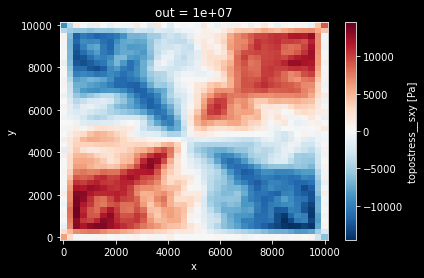

In [17]:
ds_out.topostress__sxy.isel(out=-1).plot()
print(ds_out.topostress__sxy.isel(out=-1).max().values)

We display the topography

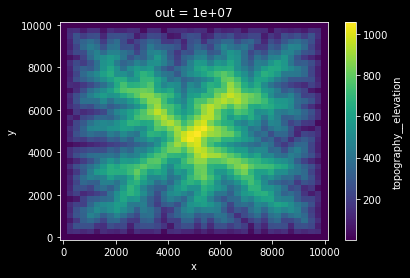

In [18]:
ds_out.topography__elevation.isel(out=-1).plot()

Note that the topography can be stored for use in another program/code by uncommenting the following line/cell

In [14]:
#np.savetxt('junk.txt',ds_out.topography__elevation.isel(out=-1).values)

## 3D visualizer

In [9]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out, canvas_height=800, time_dim="out")

app.show()

Output(layout=Layout(height='840px'))